In [2]:
# !pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="4ALnno7yPJkqwU42lvyM")
project = rf.workspace().project("dataset-100")
dataset = project.version(1).download("voc")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to dataset-100-1 in voc:: 100%|██████████| 205/205 [00:00<00:00, 770.53it/s]


In [1]:
import torch
print(torch.cuda.is_available())

# pip install detecto

True


In [1]:
from detecto import core, utils, visualize
from detecto.visualize import show_labeled_image, plot_prediction_grid
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

C:\Users\Jakob\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\pylab\config.py:70: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


In [5]:
custom_transforms = transforms.Compose([
transforms.ToPILImage(),
transforms.Resize(640),
transforms.RandomHorizontalFlip(0.5),
transforms.ColorJitter(saturation=0.2),
transforms.ToTensor(),
utils.normalize_transform(),
])

In [ ]:
Train_dataset = core.Dataset("data/train/",transform=custom_transforms)#L1
Test_dataset = core.Dataset("data/valid/")#L2
loader=core.DataLoader(Train_dataset, batch_size=2, shuffle=True)#L3
model = core.Model(["0","1","2","3"])#L4
losses = model.fit(loader, Test_dataset, epochs=25, lr_step_size=5, learning_rate=0.001, verbose=True)

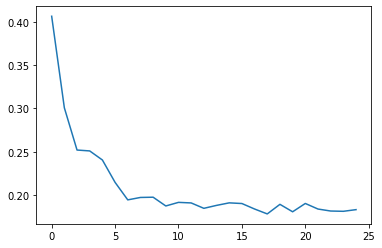

In [7]:
plt.plot(losses)
plt.show()

In [8]:
model.save("model_weights.pth")


In [ ]:
image = utils.read_image('path_to_image.jpg')
predictions = model.predict(image)

images = []
for i in range(4):
    image, _ = val_dataset[i]
    images.append(image)

top_predictions = model.predict_top(images)

print(predictions)
print(top_predictions)

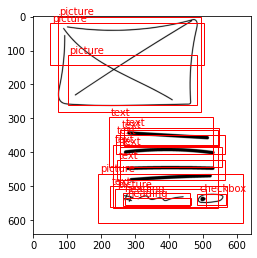

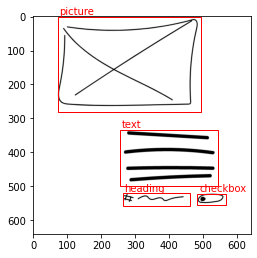

In [107]:
image = utils.read_image("testset-2/1.png") 
predictions = model.predict(image)
labels, boxes, scores = predictions
show_labeled_image(image, boxes, labels)

image = utils.read_image("testset-2/1.png") 
predictions = model.predict_top(image)
labels, boxes, scores = predictions
show_labeled_image(image, boxes, labels)

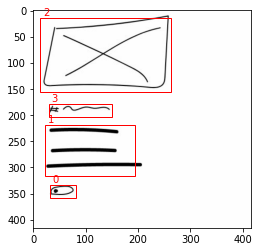

In [22]:
thresh=0.6
filtered_indices=np.where(scores>thresh)
filtered_scores=scores[filtered_indices]
filtered_boxes=boxes[filtered_indices]
num_list = filtered_indices[0].tolist()
filtered_labels = [labels[i] for i in num_list]
show_labeled_image(image, filtered_boxes, filtered_labels)

In [19]:
print(filtered_boxes)
print(num_list)

tensor([[ 73.8167,  25.8409, 367.5453, 202.9295],
        [  7.8257, 224.4822, 204.2372, 335.4298],
        [ 23.8784, 356.2332,  77.5876, 377.3986],
        [ 23.4739, 198.6438, 147.8877, 223.8855],
        [ 18.2221, 266.3311, 208.7060, 358.1029]])
[0, 1, 2, 3, 4]


In [20]:
print(filtered_labels)

['2', '1', '0', '3', '1']


In [23]:
import os

data/test/Custom-Size---21_png.rf.33187c98a75ce0a7cb3b087c3939ac15.jpg


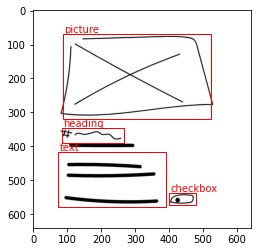

data/test/Custom-Size---62_png.rf.708371bd2b405f4d4b970333b6346144.jpg


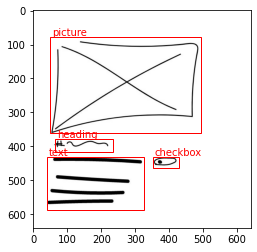

data/test/Custom-Size---73_png.rf.e7bf4e3d210e2f1a5520864e9c0cf290.jpg


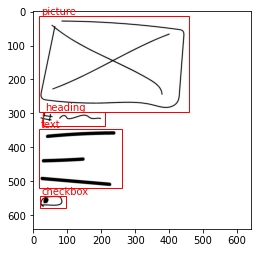

data/test/Custom-Size---7_png.rf.a62697f897465f50eebd68049dcaa88f.jpg


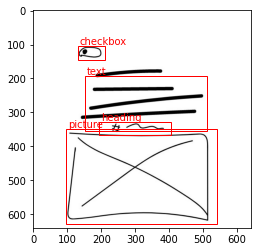

data/test/test.jpg


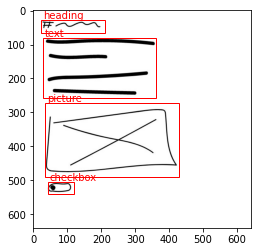

In [110]:
thresh=0.8
path = "data/test/"

for image in os.listdir(path):
  if image.endswith(".jpg"):
    print(f"{path}{image}")
    image = utils.read_image(f"{path}{image}") 
    predictions = model.predict_top(image)
    labels, boxes, scores = predictions
    
    
    filtered_indices=np.where(scores>thresh)
    filtered_scores=scores[filtered_indices]
    filtered_boxes=boxes[filtered_indices]
    num_list = filtered_indices[0].tolist()
    filtered_labels = [labels[i] for i in num_list]
    show_labeled_image(image, filtered_boxes, filtered_labels)

In [6]:
from detecto import core, utils, visualize
from detecto.visualize import show_labeled_image, plot_prediction_grid
from torchvision import transforms
import torch
import matplotlib.pyplot as plt
import numpy as np
import json, itertools, time



from detecto.core import Model
from detecto.visualize import detect_live, detect_video
model = core.Model.load("model_weights_v2.pth", ["nav","frame","heading","text","checkbox","input","button","container","footer"])

In [7]:
def merge_bounding_box(itterations, filtered_boxes, filtered_labels):
    
    filtered_boxes = filtered_boxes.tolist()
    j = 0

    while j < itterations:
        
        
        for x,y in itertools.combinations(range(len(filtered_labels)), 2):
            try:
                # print(x,y)      

                if filtered_labels[x] == filtered_labels[y]:
                    

                    x0min = filtered_boxes[x][0]
                    y0min = filtered_boxes[x][1]
                    x0max = filtered_boxes[x][2]
                    y0max = filtered_boxes[x][3]
                    
                    x1min = filtered_boxes[y][0]
                    y1min = filtered_boxes[y][1]
                    x1max = filtered_boxes[y][2]
                    y1max = filtered_boxes[y][3]

                    if ((x0min <= x1min <= x0max or x0min <= x1max <= x0max) and (y0min <= y1min <= y0max or y0min <= y1max <= y0max)) or (x1min <= x0min and x1max >= x0max and y1min <= y0min and y1max >= y0max):
                        print(True)
                        x2min = min(x0min,x1min)
                        x2max = max(x0max, x1max)

                        y2min = min(y0min, y1min)
                        y2max = max(y0max, y1max)

                        filtered_labels.append(filtered_labels[x])
                        filtered_boxes.append([x2min,y2min,x2max,y2max])
                        
                        filtered_boxes.pop(y)
                        filtered_boxes.pop(x)

                        filtered_labels.pop(y)
                        filtered_labels.pop(x)
                        break
            except Exception as e:
                break
                print(e)
        j += 1

    filtered_boxes = torch.FloatTensor(filtered_boxes)

    return filtered_boxes, filtered_labels
        

data/test-2.jpg
True
True


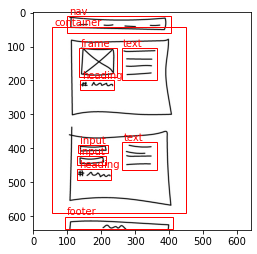

data/test-3.jpg


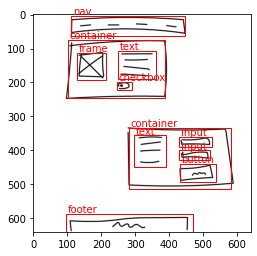

data/test-res.jpg


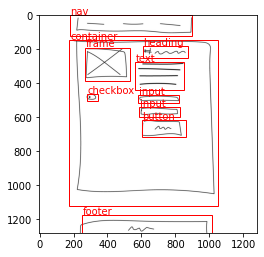

data/test-res2-100.jpg


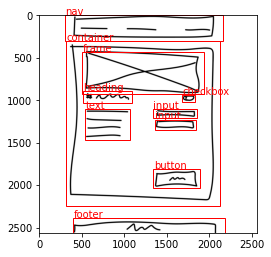

data/test-scan.jpg


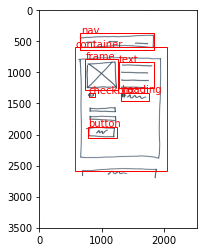

In [22]:
thresh=0.7
path = "data/"

for image in os.listdir(path):
  
  if image.endswith(".jpg"):
    print(f"{path}{image}")
    image_data = utils.read_image(f"{path}{image}") 
    predictions = model.predict(image_data)
    labels, boxes, scores = predictions
    
    
    filtered_indices=np.where(scores>thresh)
    filtered_scores=scores[filtered_indices]
    filtered_boxes=boxes[filtered_indices]
    num_list = filtered_indices[0].tolist()
    filtered_labels = [labels[i] for i in num_list]

    filtered_boxes, filtered_labels = merge_bounding_box(5, filtered_boxes, filtered_labels)

    show_labeled_image(image_data, filtered_boxes, filtered_labels)


In [93]:
i = 0
for image in os.listdir(path):
    os.rename(f"testset-2/{image}",f"{i}.png")
    i +=1

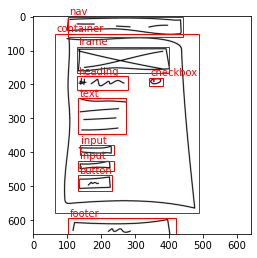

In [19]:
thresh = 0.78
image_data = utils.read_image(f"data/testset/1.jpg") 
predictions = model.predict(image_data)
labels, boxes, scores = predictions


filtered_indices=np.where(scores>thresh)
filtered_scores=scores[filtered_indices]
filtered_boxes=boxes[filtered_indices]
num_list = filtered_indices[0].tolist()
filtered_labels = [labels[i] for i in num_list]

filtered_boxes, filtered_labels = merge_bounding_box(5, filtered_boxes, filtered_labels)

show_labeled_image(image_data, filtered_boxes, filtered_labels)
